# N6 signature

# 0. Loading the libraries

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.gridspec as grid_spec
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler
from sklearn.neighbors import KernelDensity
import joypy
import scrublet as scr
import scvelo as scv
import gseapy as gp
from gseapy.plot import barplot, dotplot

from matplotlib_venn import venn3, venn2
import diffxpy.api as de
from bioinfokit import analys, visuz
import xlsxwriter

import normalisr.normalisr as norm
from os.path import join as pjoin
import statsmodels
from adjustText import adjust_text

import pickle
import os

def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

2022-06-17 10:12:50.646744: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/R/lib/R/lib:
2022-06-17 10:12:50.646965: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3

In [3]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

# 1. Reading in the data

[Timing: 35s reading from cache]

In [4]:
# Load the pre-processed data
with open('saved_objects/adata_annotated.pkl', 'rb') as inp:
    adata = pickle.load(inp)

In [5]:
#from sklearn.preprocessing import StandardScaler
#std_scaler = StandardScaler()

In [34]:
def myc_n6_hm(data, BIGLIST, name, tickcolors):
    
    # filter genes
    data = data[:,data.var["gene_name"].isin(BIGLIST)]

    # add column
    newcol = []
    for i in range(len(data.obs)):
        line = data.obs.iloc[i, :]
        if line['tp']=='0h' : add='NAIVE'
        else:
            add = line['cond'] + "_" + line['Myc_positive'] + "_" + line['tp']
        newcol.append(add)
    data.obs['heatmap'] = newcol

    # create df
    COLUMNS = ["NAIVE", "DMSO_Myc+_2h", "N6_Myc+_2h", "DMSO_Myc-_2h", "N6_Myc-_2h", 
                    "DMSO_Myc+_24h", "N6_Myc+_24h", "DMSO_Myc-_24h", "N6_Myc-_24h", 
                    "DMSO_Myc+_48h", "N6_Myc+_48h", "DMSO_Myc-_48h", "N6_Myc-_48h", 
                    "DMSO_Myc+_d7", "N6_Myc+_d7", "DMSO_Myc-_d7", "N6_Myc-_d7"]

    summary_df = pd.DataFrame(data.X, index = data.obs.index, columns = data.var.index)
    summary_df = summary_df.groupby(data.obs['heatmap']).mean().T
    summary_df = summary_df[COLUMNS].T
    '''
    # scale df
    df_scaled = std_scaler.fit_transform(summary_df.values)
    df_scaled = pd.DataFrame(df_scaled, columns = summary_df.columns, index = summary_df.index)
    '''
    # save hm
    hm = sb.clustermap(summary_df, col_cluster = True, row_cluster = False, 
        cmap = sb.color_palette("coolwarm", as_cmap=True), yticklabels=True, 
        center=0,linewidths=1, linecolor='grey',clip_on=False)
    hm.cax.set_visible(False)
    hm.ax_col_dendrogram.set_visible(True)
    hm.ax_heatmap.set_aspect("equal")
    plt.setp(hm.ax_heatmap.xaxis.get_majorticklabels(), rotation=40, va="center", position=(0,-0.04))
    
    for ticklabel, tickcolor in zip(hm.ax_heatmap.get_xticklabels(), tickcolors):
        ticklabel.set_color(tickcolor)
    
    hm.fig.savefig("figures/"+"heatmap_cc_"+name+".png")

In [39]:
def nomyc_n6_hm(data, BIGLIST, name, tickcolors):
    
    # filter genes
    data = data[:,data.var["gene_name"].isin(BIGLIST)]

    # add column
    newcol = []
    for i in range(len(data.obs)):
        line = data.obs.iloc[i, :]
        if line['tp']=='0h' : add='NAIVE'
        else:
            add = line['cond'] + "_" + line['tp']
        newcol.append(add)
    data.obs['heatmap'] = newcol

    # create df
    COLUMNS = ["NAIVE", "DMSO_2h", "N6_2h",
                    "DMSO_24h", "N6_24h",
                    "DMSO_48h", "N6_48h",
                    "DMSO_d7", "N6_d7"]

    summary_df = pd.DataFrame(data.X, index = data.obs.index, columns = data.var.index)
    summary_df = summary_df.groupby(data.obs['heatmap']).mean().T
    summary_df = summary_df[COLUMNS].T
    '''
    # scale df
    df_scaled = std_scaler.fit_transform(summary_df.values)
    df_scaled = pd.DataFrame(df_scaled, columns = summary_df.columns, index = summary_df.index)
    '''
    # save hm
    hm = sb.clustermap(summary_df, col_cluster = True, row_cluster = False, 
        cmap = sb.color_palette("coolwarm", as_cmap=True), yticklabels=True, 
        center=0,linewidths=1, linecolor='grey',clip_on=False)
    hm.cax.set_visible(False)
    hm.ax_col_dendrogram.set_visible(True)
    hm.ax_heatmap.set_aspect("equal")
    plt.setp(hm.ax_heatmap.xaxis.get_majorticklabels(), rotation=40, va="center", position=(0,-0.07))
    
    for ticklabel, tickcolor in zip(hm.ax_heatmap.get_xticklabels(), tickcolors):
        ticklabel.set_color(tickcolor)
    
    hm.fig.savefig("figures/"+"heatmap_cc_"+name+".png")

## 2. Heatmaps

79


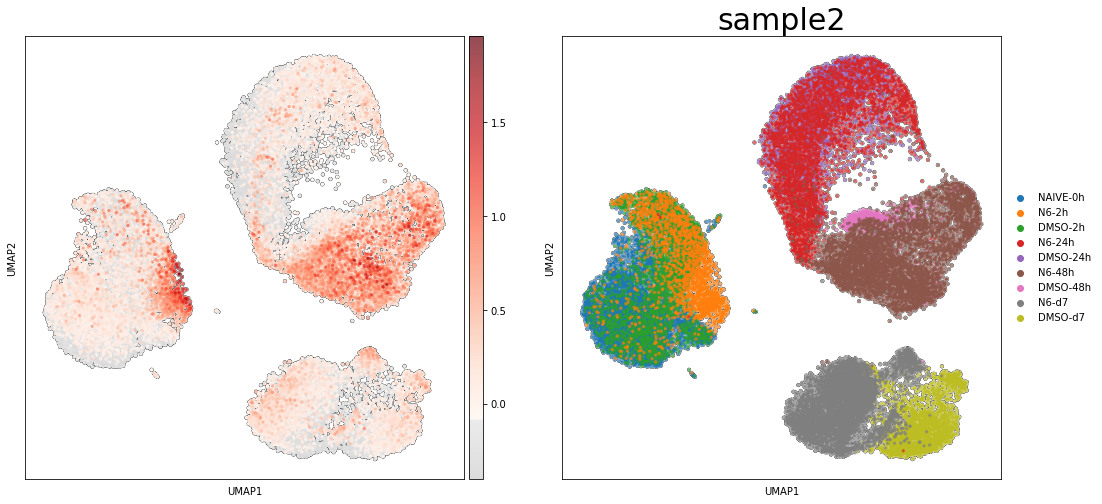

In [73]:
BIGLIST = pd.read_excel("figures/deg11_N6vsDMSO_2h_normalisr.xlsx", sheet_name = "significant")
BIGLIST = BIGLIST[BIGLIST.fc > 5].gene.tolist()
print(len(BIGLIST))
name = "2h+"
df = pd.DataFrame(columns=BIGLIST, index=adata.obs.index)
for mark in BIGLIST:
    df[mark] = adata.X[:, adata.var['gene_name'] == mark]
adata.obs[name] = df.mean(axis=1)
sc.pl.umap(adata, cmap = mymap, color = [name, 'sample2'], size = 40, add_outline = True, outline_width = [0.1, 0.05],
             ncols = 2, title = "", save = "_"+name+".png")

16


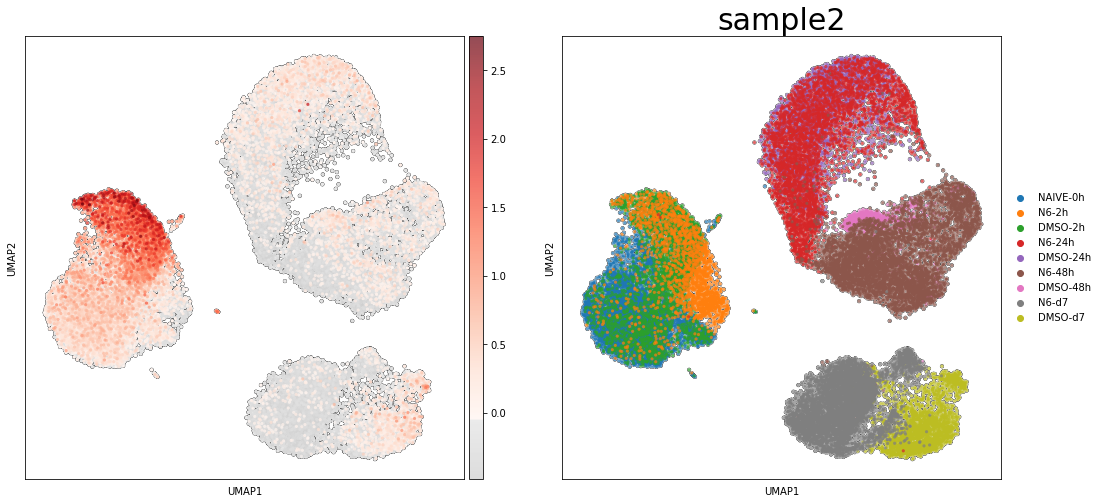

In [74]:
BIGLIST = pd.read_excel("figures/deg11_N6vsDMSO_2h_normalisr.xlsx", sheet_name = "significant")
BIGLIST = BIGLIST[BIGLIST.fc < 0.2].gene.tolist()
print(len(BIGLIST))
name = "2h-"
df = pd.DataFrame(columns=BIGLIST, index=adata.obs.index)
for mark in BIGLIST:
    df[mark] = adata.X[:, adata.var['gene_name'] == mark]
adata.obs[name] = df.mean(axis=1)
sc.pl.umap(adata, cmap = mymap, color = [name, 'sample2'], size = 40, add_outline = True, outline_width = [0.1, 0.05],
             ncols = 2, title = "", save = "_"+name+".png")

In [97]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,60))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

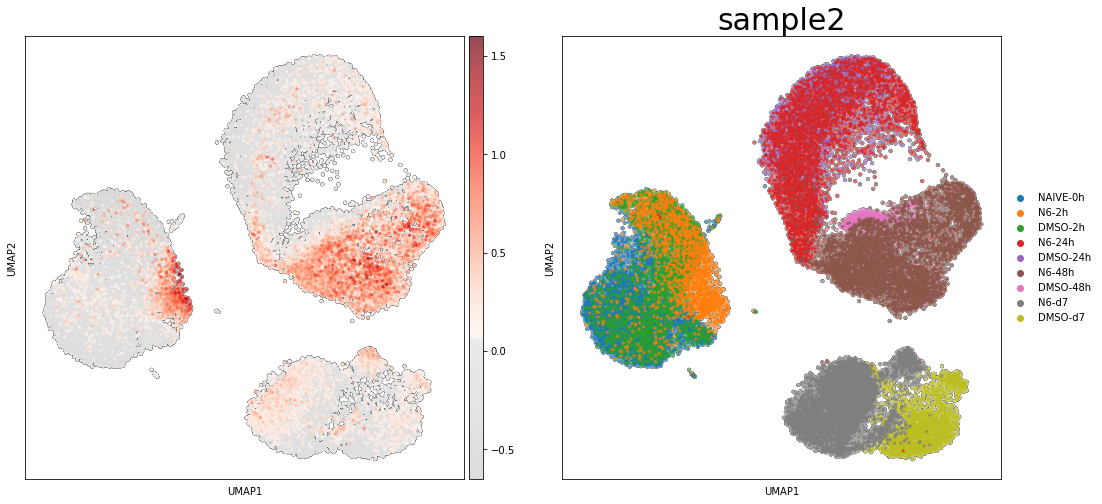

In [98]:
BIGLIST = pd.read_excel("figures/deg11_N6vsDMSO_2h_normalisr.xlsx", sheet_name = "significant")
name = "2h_sum"
df = pd.DataFrame(columns=BIGLIST[(BIGLIST.fc > 5) | (BIGLIST.fc < 0.2)].gene.tolist(), index=adata.obs.index)

BIGLISTp = BIGLIST[BIGLIST.fc > 5].gene.tolist()
BIGLISTn = BIGLIST[BIGLIST.fc < 0.2].gene.tolist()

for mark in BIGLISTp:
    df[mark] = adata.X[:, adata.var['gene_name'] == mark]
for mark in BIGLISTn:
    df[mark] = -adata.X[:, adata.var['gene_name'] == mark]
adata.obs[name] = df.mean(axis=1)

sc.pl.umap(adata, cmap = mymap, color = [name, 'sample2'], size = 40, add_outline = True, outline_width = [0.1, 0.05],
             ncols = 2, title = "", save = "_"+name+".png")

## 2.7 N6vsDMSO_myc

In [20]:
deg1 = pd.read_excel("figures/deg11_N6vsDMSO_2h_normalisr.xlsx", sheet_name = "significant")
l1 = deg1.gene.tolist()
deg2 = pd.read_excel("figures/deg11_N6vsDMSO_24h_normalisr.xlsx", sheet_name = "significant")
l2 = deg2.gene.tolist()
deg3 = pd.read_excel("figures/deg11_N6vsDMSO_48h_normalisr.xlsx", sheet_name = "significant")
l3 = deg3.gene.tolist()
deg4 = pd.read_excel("figures/deg11_N6vsDMSO_d7_normalisr.xlsx", sheet_name = "significant")
l4 = deg4.gene.tolist()
n6_6 = pd.read_csv("files/affy_6h_annotated_liste_de_0.01_Pack1_Pack2.txt", sep = "\t")[["Symbol", "logFC", "Ratio"]]
n6_6 = n6_6[n6_6.Symbol == n6_6.Symbol]
n6_6["Gene"] = [e.split(", ")[0] if len(e.split(", ")) > 1 else e for e in n6_6["Symbol"]]
deg5 = n6_6[n6_6.Gene.isin(adata.var_names.tolist())]
deg5.columns = ["Symbol", 'log2fc', 'fc', 'gene']
deg5['fc'] = [1/e for e in deg5['fc']]
deg5['log2fc'] = [-e for e in deg5['log2fc']]
l5 = deg5.gene.tolist()

In [21]:
all_genes = set(l1+l2+l3+l4+l5)
hmdata = pd.DataFrame(index=all_genes)
degs = [deg1, deg2, deg3, deg4, deg5]
name_degs = ['2h', '24h', '48h', 'd7', '6h']

b = 1
for i in range(5):

    hmdata[name_degs[i]] = 0
    for gene in degs[i][degs[i]['fc'] > b]['gene'].tolist():
        hmdata.loc[gene, name_degs[i]] = 1
    for gene in degs[i][degs[i]['fc'] < (1/b)]['gene'].tolist():
        hmdata.loc[gene, name_degs[i]] = -1

In [27]:
BIGLIST = []
for i in range(len(hmdata)):
    pos = [e for e in hmdata.iloc[i, :] if e > 0]
    neg = [e for e in hmdata.iloc[i, :] if e < 0]
    if (len(pos) >= 4) or (len(neg) >= 4):
        BIGLIST.append(hmdata.index[i])
print(len(BIGLIST))

20


In [28]:
name = "N6vsDMSO_myc"
df = pd.DataFrame(BIGLIST, columns=[name])
df.to_csv('gene_lists/'+name+'.csv', index=False)

In [32]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures

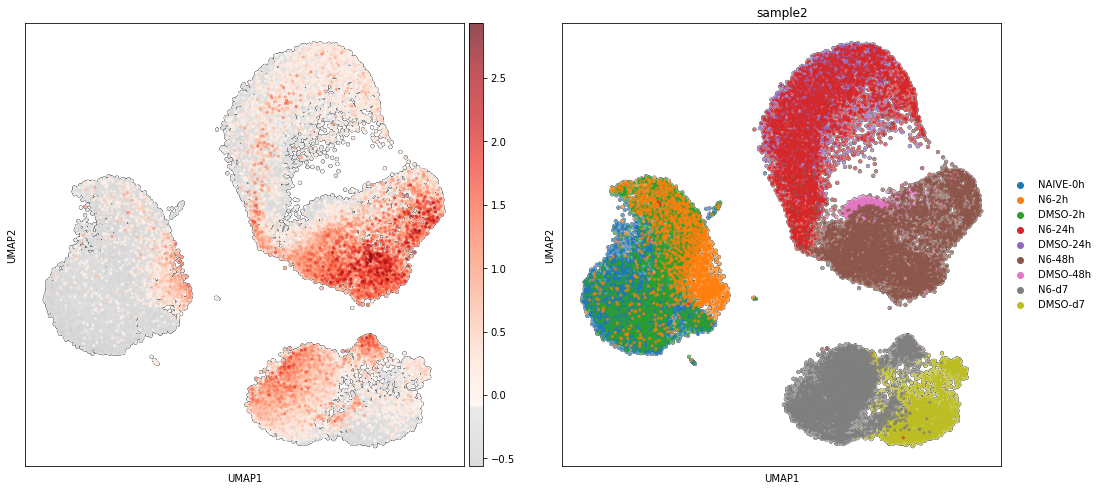

In [33]:
df = pd.DataFrame(columns=BIGLIST, index=adata.obs.index)
for mark in BIGLIST:
    df[mark] = adata.X[:, adata.var['gene_name'] == mark]
adata.obs[name] = df.mean(axis=1)
sc.pl.umap(adata, cmap = mymap, color = [name, 'sample2'], size = 40, add_outline = True, outline_width = [0.1, 0.05],
             ncols = 2, title = "", save = "_"+name+".png")

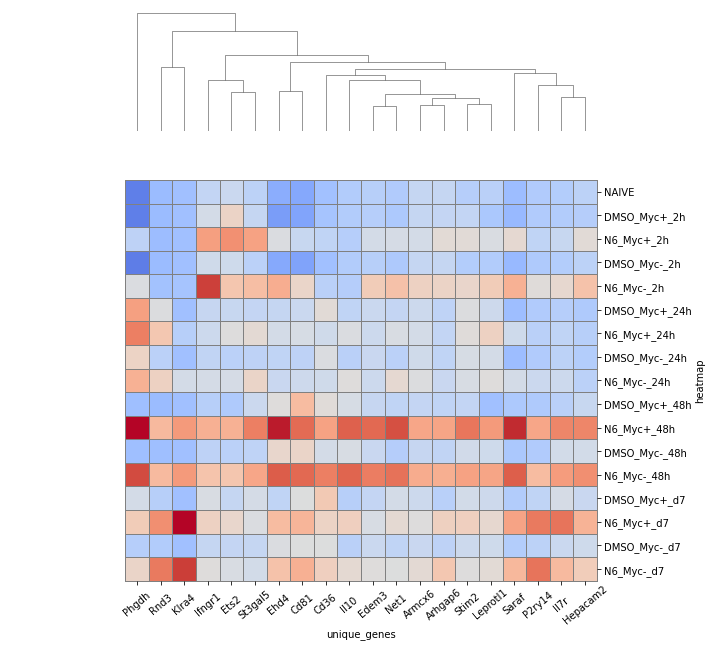

In [41]:
name = "N6vsDMSO_myc"
tkc = ['black']*20
myc_n6_hm(adata, BIGLIST, name, tickcolors = tkc)

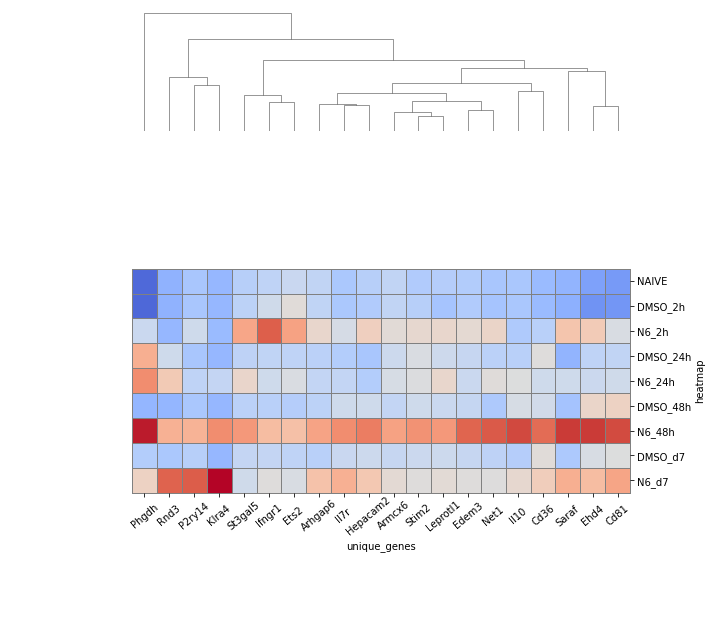

In [42]:
name = "N6vsDMSO_nomyc"
tkc = ['black']*20
nomyc_n6_hm(adata, BIGLIST, name, tickcolors = tkc)

# 3 Functional enrichment

## 3.0 deg il10+ vs - 48h

In [33]:
file1 = pd.read_excel("figures/deg11_IL10PosvsNeg_N6-48h_normalisr.xlsx", sheet_name="enriched").iloc[[1,3,4,5,7,8,9]]
file1 = file1.reset_index(drop=True)

all_genes = []
for i in range(len(file1)):
    genes = file1.iloc[i, 5].split(';')
    all_genes += genes
all_genes = list(set(all_genes))

file2 = pd.read_excel("figures/deg11_IL10PosvsNeg_N6-48h_normalisr.xlsx", sheet_name="everything")
file2['GENE'] = [str(e).upper() for e in file2.gene]
file2 = file2[file2.GENE.isin(all_genes)]
file2 = file2.set_index("GENE")

In [34]:
hm = pd.DataFrame(columns = all_genes, index = file1.Term)

for i in range(len(file1)):
    term = file1.Term[i]
    for gene in file1.iloc[i, 5].split(';'):
        hm.loc[term, gene] = file2.loc[gene, 'log2fc']

mask = hm.isnull()
hm = hm.replace(np.nan, 0)

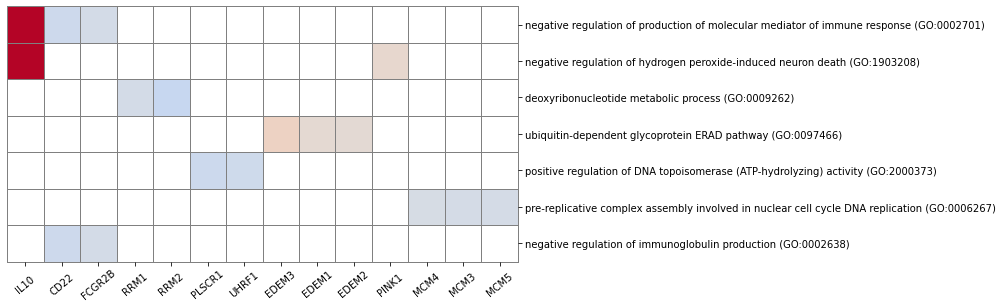

In [35]:
cg = sb.clustermap(hm, mask=mask, cmap = sb.color_palette("coolwarm", as_cmap=True), center=0,linewidths=1, linecolor='grey',
        clip_on=False, cbar=None, figsize=(16,5))
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.cax.set_visible(False)
ax = cg.ax_heatmap
ax.set_aspect("equal")
ax.set_ylabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, va="center", position=(0,-0.06))
cg.savefig("figures/"+"enrich_"+"N6-48h-il10posvsneg"+".png")

In [36]:
file1 = pd.read_excel("figures/deg11_IL10HighvsLow_N6-48h_normalisr.xlsx", sheet_name="enriched").iloc[[0,1,2,3,4,5,6,7,8,9]]
file1 = file1.reset_index(drop=True)

all_genes = []
for i in range(len(file1)):
    genes = file1.iloc[i, 5].split(';')
    all_genes += genes
all_genes = list(set(all_genes))

file2 = pd.read_excel("figures/deg11_IL10HighvsLow_N6-48h_normalisr.xlsx", sheet_name="everything")
file2['GENE'] = [str(e).upper() for e in file2.gene]
file2 = file2[file2.GENE.isin(all_genes)]
file2 = file2.set_index("GENE")

In [37]:
hm = pd.DataFrame(columns = all_genes, index = file1.Term)

for i in range(len(file1)):
    term = file1.Term[i]
    for gene in file1.iloc[i, 5].split(';'):
        hm.loc[term, gene] = file2.loc[gene, 'log2fc']

mask = hm.isnull()
hm = hm.replace(np.nan, 0)

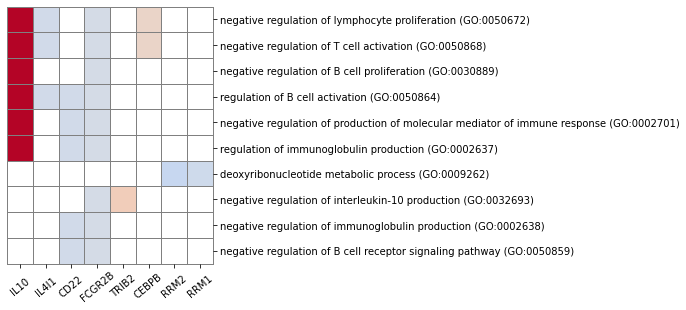

In [38]:
cg = sb.clustermap(hm, mask=mask, cmap = sb.color_palette("coolwarm", as_cmap=True), center=0,linewidths=1, linecolor='grey',
        clip_on=False, cbar=None, figsize=(16,5))
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.cax.set_visible(False)
ax = cg.ax_heatmap
ax.set_aspect("equal")
ax.set_ylabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, va="center", position=(0,-0.06))
cg.savefig("figures/"+"enrich_"+"N6-48h-il10highvslow"+".png")

In [39]:
file1 = pd.read_excel("figures/deg11_IL10PosvsNeg_N6-24h_normalisr.xlsx", sheet_name="enriched").iloc[[0,1,2,3,4,5,6,7,8,9]]
file1 = file1.reset_index(drop=True)

all_genes = []
for i in range(len(file1)):
    genes = file1.iloc[i, 5].split(';')
    all_genes += genes
all_genes = list(set(all_genes))

file2 = pd.read_excel("figures/deg11_IL10PosvsNeg_N6-24h_normalisr.xlsx", sheet_name="everything")
file2['GENE'] = [str(e).upper() for e in file2.gene]
file2 = file2[file2.GENE.isin(all_genes)]
file2 = file2.set_index("GENE")

In [40]:
hm = pd.DataFrame(columns = all_genes, index = file1.Term)

for i in range(len(file1)):
    term = file1.Term[i]
    for gene in file1.iloc[i, 5].split(';'):
        hm.loc[term, gene] = file2.loc[gene, 'log2fc']

mask = hm.isnull()
hm = hm.replace(np.nan, 0)

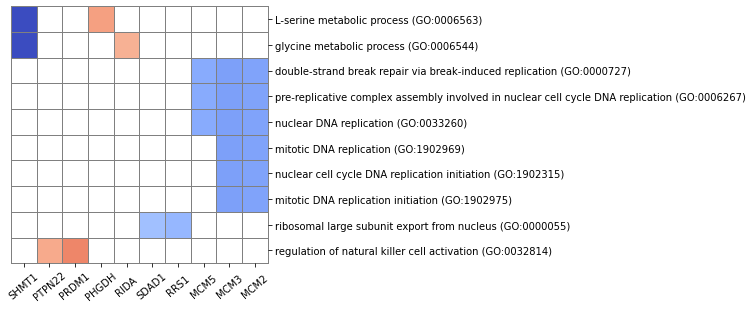

In [41]:
cg = sb.clustermap(hm, mask=mask, cmap = sb.color_palette("coolwarm", as_cmap=True), center=0,linewidths=1, linecolor='grey',
        clip_on=False, cbar=None, figsize=(16,5))
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.cax.set_visible(False)
ax = cg.ax_heatmap
ax.set_aspect("equal")
ax.set_ylabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, va="center", position=(0,-0.06))
cg.savefig("figures/"+"enrich_"+"N6-24h-il10posvsneg"+".png")

In [42]:
file1 = pd.read_excel("figures/coex_N6-24h_Il10.xlsx", sheet_name="enriched").iloc[[0,1,2,3,4,5,6,7,8,9]]
file1 = file1.reset_index(drop=True)

all_genes = []
for i in range(len(file1)):
    genes = file1.iloc[i, 5].split(';')
    all_genes += genes
all_genes = list(set(all_genes))

file2 = pd.read_excel("figures/coex_N6-24h_Il10.xlsx", sheet_name="everything")
file2['GENE'] = [str(e).upper() for e in file2.gene]
file2 = file2[file2.GENE.isin(all_genes)]
file2 = file2.set_index("GENE")

In [43]:
hm = pd.DataFrame(columns = all_genes, index = file1.Term)

for i in range(len(file1)):
    term = file1.Term[i]
    for gene in file1.iloc[i, 5].split(';'):
        hm.loc[term, gene] = file2.loc[gene, 'mean']

mask = hm.isnull()
hm = hm.replace(np.nan, 0)

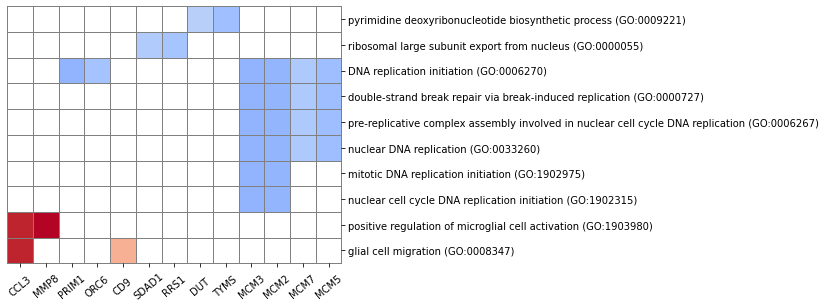

In [44]:
cg = sb.clustermap(hm, mask=mask, cmap = sb.color_palette("coolwarm", as_cmap=True), center=0,linewidths=1, linecolor='grey',
        clip_on=False, cbar=None, figsize=(16,5))
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.cax.set_visible(False)
ax = cg.ax_heatmap
ax.set_aspect("equal")
ax.set_ylabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, va="center", position=(0,-0.06))
cg.savefig("figures/"+"enrich_"+"N6-24h"+".png")

In [52]:
file1 = pd.read_excel("figures/deg11_N6vsDMSO_d7_normalisr.xlsx", sheet_name="enriched").iloc[[0,1,3,4,7,8]]
file1 = file1.reset_index(drop=True)

all_genes = []
for i in range(len(file1)):
    genes = file1.iloc[i, 5].split(';')
    all_genes += genes
all_genes = list(set(all_genes))

file2 = pd.read_excel("figures/deg11_N6vsDMSO_d7_normalisr.xlsx", sheet_name="everything")
file2['GENE'] = [str(e).upper() for e in file2.gene]
file2 = file2[file2.GENE.isin(all_genes)]
file2 = file2.set_index("GENE")

In [53]:
hm = pd.DataFrame(columns = all_genes, index = file1.Term)

for i in range(len(file1)):
    term = file1.Term[i]
    for gene in file1.iloc[i, 5].split(';'):
        hm.loc[term, gene] = file2.loc[gene, 'mean']

mask = hm.isnull()
hm = hm.replace(np.nan, 0)

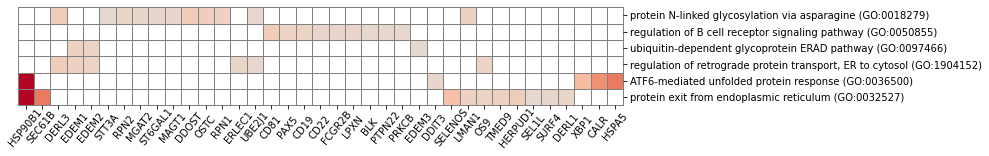

In [56]:
cg = sb.clustermap(hm, mask=mask, cmap = sb.color_palette("coolwarm", as_cmap=True), center=0,linewidths=1, linecolor='grey',
        clip_on=False, cbar=None, figsize=(16,5))
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.cax.set_visible(False)
ax = cg.ax_heatmap
ax.set_aspect("equal")
ax.set_ylabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 50, va="center", position=(0,-0.15))
cg.savefig("figures/"+"n6vsdmso_d7"+".png")

## 3.1 48h Il-10 co-expression

In [62]:
file1 = pd.read_excel("figures/coex_N6-48h_Il10.xlsx", sheet_name="enriched").iloc[[0,2,4,5,6,7,8,9]] #[1,2,3,6,7,9,10,13]
file1 = file1.reset_index(drop=True)

all_genes = []
for i in range(len(file1)):
    genes = file1.iloc[i, 5].split(';')
    all_genes += genes
all_genes = list(set(all_genes))

file2 = pd.read_excel("figures/coex_N6-48h_Il10.xlsx", sheet_name="everything")
file2['GENE'] = [str(e).upper() for e in file2.gene]
file2 = file2[file2.GENE.isin(all_genes)]
file2 = file2.set_index("GENE")

In [63]:
hm = pd.DataFrame(columns = all_genes, index = file1.Term)

for i in range(len(file1)):
    term = file1.Term[i]
    for gene in file1.iloc[i, 5].split(';'):
        hm.loc[term, gene] = file2.loc[gene, 'mean']

mask = hm.isnull()
hm = hm.replace(np.nan, 0)

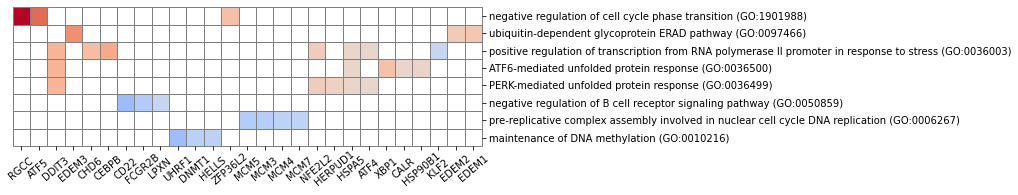

In [65]:
cg = sb.clustermap(hm, mask=mask, cmap = sb.color_palette("coolwarm", as_cmap=True), center=0,linewidths=1, linecolor='grey',
        clip_on=False, cbar=None, figsize=(16,5))
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.cax.set_visible(False)
ax = cg.ax_heatmap
ax.set_aspect("equal")
ax.set_ylabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 40, va="center", position=(0,-0.11))
cg.savefig("figures/"+"enrich_"+"N6-48h-il10"+".png")

## 3.2 24h Il-10 co-expression

In [78]:
file1 = pd.read_excel("figures/coex_N6-24h_Il10.xlsx", sheet_name="enriched").iloc[[0,1,2,3,4]]
file1 = file1.reset_index(drop=True)

all_genes = []
for i in range(len(file1)):
    genes = file1.iloc[i, 5].split(';')
    all_genes += genes
all_genes = list(set(all_genes))

file2 = pd.read_excel("figures/coex_N6-24h_Il10.xlsx", sheet_name="everything")
file2['GENE'] = [str(e).upper() for e in file2.gene]
file2 = file2[file2.GENE.isin(all_genes)]
file2 = file2.set_index("GENE")

In [79]:
hm = pd.DataFrame(columns = all_genes, index = file1.Term)

for i in range(len(file1)):
    term = file1.Term[i]
    for gene in file1.iloc[i, 5].split(';'):
        hm.loc[term, gene] = file2.loc[gene, 'mean']

from textwrap import wrap
hm.index = ['\n'.join(wrap(x, 50)) for x in hm.index]

mask = hm.isnull()
hm = hm.replace(np.nan, 0)

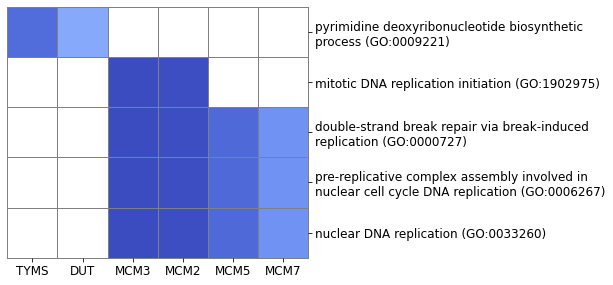

In [80]:
font = {'size' : 12}
plt.rc('font', **font)

cg = sb.clustermap(hm, mask=mask, cmap = sb.color_palette("coolwarm", as_cmap=True), center=0,linewidths=1, linecolor='grey',
        clip_on=False, cbar=None, figsize=(16,5))
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.cax.set_visible(False)
ax = cg.ax_heatmap
ax.set_aspect("equal")
ax.set_ylabel("")
cg.savefig("figures/"+"enrich_"+"N6-24h-il10"+".png")

## 3.2 d7 n6 vs dmso

In [180]:
file1 = pd.read_excel("figures/deg11_N6vsDMSO_d7_normalisr.xlsx", sheet_name="enriched").iloc[[0,1,2,3,4]]
file1 = file1.reset_index(drop=True)

all_genes = []
for i in range(len(file1)):
    genes = file1.iloc[i, 5].split(';')
    all_genes += genes
all_genes = list(set(all_genes))

file2 = pd.read_excel("figures/deg11_N6vsDMSO_d7_normalisr.xlsx", sheet_name="everything")
file2['GENE'] = [str(e).upper() for e in file2.gene]
file2 = file2[file2.GENE.isin(all_genes)]
file2 = file2.set_index("GENE")

In [183]:
hm = pd.DataFrame(columns = all_genes, index = file1.Term)

for i in range(len(file1)):
    term = file1.Term[i]
    for gene in file1.iloc[i, 5].split(';'):
        hm.loc[term, gene] = file2.loc[gene, 'mean']

from textwrap import wrap
hm.index = ['\n'.join(wrap(x, 80)) for x in hm.index]

mask = hm.isnull()
hm = hm.replace(np.nan, 0)

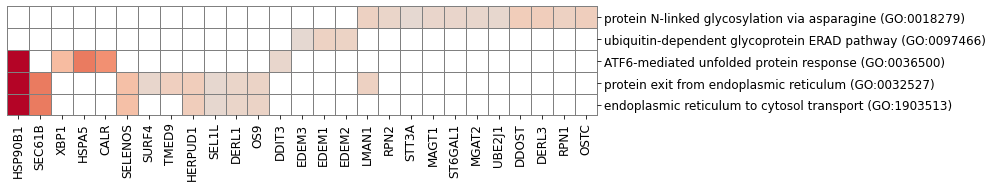

In [184]:
font = {'size' : 12}
plt.rc('font', **font)

cg = sb.clustermap(hm, mask=mask, cmap = sb.color_palette("coolwarm", as_cmap=True), center=0,linewidths=1, linecolor='grey',
        clip_on=False, cbar=None, figsize=(16,5))
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.cax.set_visible(False)
ax = cg.ax_heatmap
ax.set_aspect("equal")
ax.set_ylabel("")
cg.savefig("figures/"+"enrich_"+"N6vsDMSO-d7"+".png")

In [ ]:
file1 = pd.read_excel("figures/deg11_Il10PosvsNeg_d7_normalisr.xlsx", sheet_name="enriched").iloc[[0,1,2,3,4]]
file1 = file1.reset_index(drop=True)

all_genes = []
for i in range(len(file1)):
    genes = file1.iloc[i, 5].split(';')
    all_genes += genes
all_genes = list(set(all_genes))

file2 = pd.read_excel("figures/deg11_Il10PosvsNeg_d7_normalisr.xlsx", sheet_name="everything")
file2['GENE'] = [str(e).upper() for e in file2.gene]
file2 = file2[file2.GENE.isin(all_genes)]
file2 = file2.set_index("GENE")

In [ ]:
hm = pd.DataFrame(columns = all_genes, index = file1.Term)

for i in range(len(file1)):
    term = file1.Term[i]
    for gene in file1.iloc[i, 5].split(';'):
        hm.loc[term, gene] = file2.loc[gene, 'mean']

from textwrap import wrap
hm.index = ['\n'.join(wrap(x, 80)) for x in hm.index]

mask = hm.isnull()
hm = hm.replace(np.nan, 0)

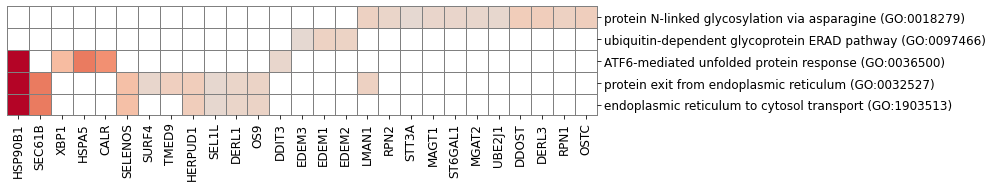

In [ ]:
font = {'size' : 12}
plt.rc('font', **font)

cg = sb.clustermap(hm, mask=mask, cmap = sb.color_palette("coolwarm", as_cmap=True), center=0,linewidths=1, linecolor='grey',
        clip_on=False, cbar=None, figsize=(16,5))
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.cax.set_visible(False)
ax = cg.ax_heatmap
ax.set_aspect("equal")
ax.set_ylabel("")
cg.savefig("figures/"+"enrich_"+"IL10posvsneg-d7"+".png")

## 3.2 N6 vs DMSO IL10-_48h

In [109]:
file1 = pd.read_excel("figures/deg11_N6vsDMSO_IL10Neg48h_normalisr.xlsx", sheet_name="enriched").iloc[[0,1,2,3,4,5,6]]
file1 = file1.reset_index(drop=True)

all_genes = []
for i in range(len(file1)):
    genes = file1.iloc[i, 5].split(';')
    all_genes += genes
all_genes = list(set(all_genes))

file2 = pd.read_excel("figures/deg11_N6vsDMSO_IL10Neg48h_normalisr.xlsx", sheet_name="everything")
file2['GENE'] = [str(e).upper() for e in file2.gene]
file2 = file2[file2.GENE.isin(all_genes)]
file2 = file2.set_index("GENE")

In [112]:
hm = pd.DataFrame(columns = all_genes, index = file1.Term)

for i in range(len(file1)):
    term = file1.Term[i]
    for gene in file1.iloc[i, 5].split(';'):
        hm.loc[term, gene] = file2.loc[gene, 'mean']

from textwrap import wrap
hm.index = ['\n'.join(wrap(x, 80)) for x in hm.index]

mask = hm.isnull()
hm = hm.replace(np.nan, 0)

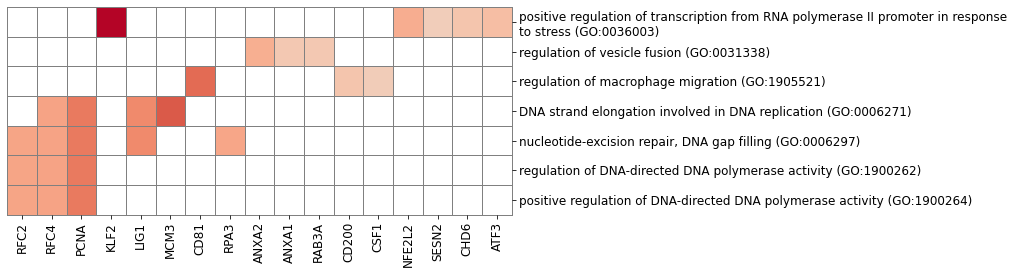

In [113]:
font = {'size' : 12}
plt.rc('font', **font)

cg = sb.clustermap(hm, mask=mask, cmap = sb.color_palette("coolwarm", as_cmap=True), center=0,linewidths=1, linecolor='grey',
        clip_on=False, cbar=None, figsize=(16,5))
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.cax.set_visible(False)
ax = cg.ax_heatmap
ax.set_aspect("equal")
ax.set_ylabel("")
cg.savefig("figures/"+"enrich_"+"N6vsDMSO_IL10Neg48h"+".png")

# 4. Venn diagram

In [66]:
A = pd.read_excel("figures/coex_N6-48h_Il10.xlsx", sheet_name="GWAS", header = 1)
A = [A[g].tolist() for g in ['gene', 'gene.1', 'gene.2', 'gene.3', 'gene.4']]
A = set([e for s in A for e in s if e==e])

In [67]:
B = pd.read_excel("figures/coex_N6-48h_Il10.xlsx", sheet_name="transcrip° factor").gene.tolist()
B = set(B[:B.index(np.nan)])

In [68]:
C = pd.read_excel("figures/coex_N6-48h_Il10.xlsx", sheet_name="ATAC", header = 1)
C = [C[g].tolist() for g in ['gene', 'gene.1']]
C = set([e for s in C for e in s if e==e])

In [91]:
D = set(pd.read_excel("figures/deg11_IL10HighvsLow_N6-48h_normalisr.xlsx", sheet_name="significant").gene.tolist())

In [94]:
', '.join(A&D-B-C)

'Rgcc, Fcgr2b, Trib2, Cbfa2t3, Svil'

In [74]:
len(A|B|C)

121

In [70]:
len(B)

39

In [71]:
len(C)

49

# 4. Dot plots

In [21]:
# add column
newcol = []
for i in range(len(adata.obs)):
    line = adata.obs.iloc[i, :]
    if line['tp']=='0h' : add='0h'
    else:
        add = line['cond'] + "_" + line['tp'] + "_" + line['Il10_positive']
    newcol.append(add)
adata.obs['heatmap'] = newcol

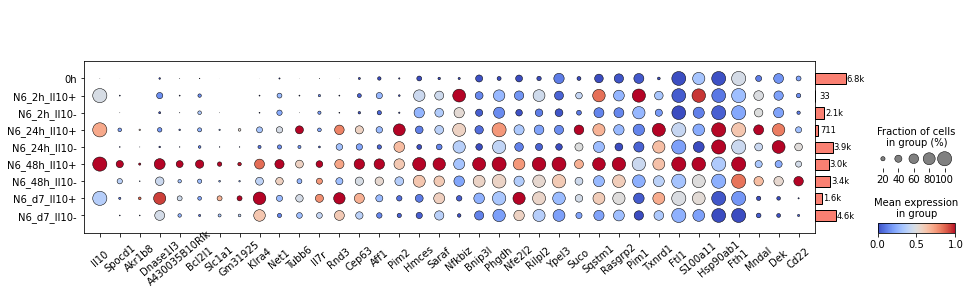

In [22]:
markers = ['Il10'] + pd.read_excel("figures/coex_inter_Il10.xlsx").gene.tolist()
dp = sc.pl.dotplot(adata[adata.obs.cond != "DMSO"], markers, groupby="heatmap", return_fig = True,
                  swap_axes = False, standard_scale = 'var')

dp = dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5, cmap = "coolwarm")
ax = dp.get_axes()['mainplot_ax']
ax.set_xticklabels(markers, rotation = 40, va="center", position=(0,-0.11))
plt.savefig("figures/inter_il10_dotplot.pdf", bbox_inches='tight')

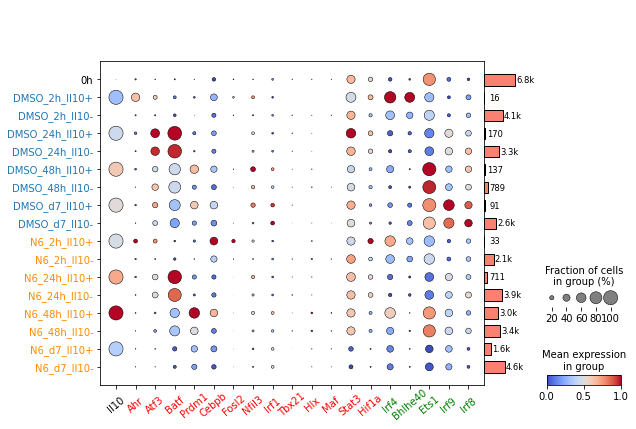

In [45]:
font = {'size' : 12}
plt.rc('font', **font)

markers = ['Il10'] + ["Ahr", "Atf3", "Batf", "Prdm1", "Cebpb", "Fosl2", "Nfil3", "Irf1", "Tbx21", "Hlx", "Maf", "Stat3", "Hif1a", 
                      "Irf4", "Bhlhe40", "Ets1", "Irf9", "Irf8"]
dp = sc.pl.dotplot(adata, markers, groupby="heatmap", return_fig = True,
                  swap_axes = False, standard_scale = 'var')

dp = dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5, cmap = "coolwarm")
ax = dp.get_axes()['mainplot_ax']
ax.set_xticklabels(markers, rotation = 40, va="center", position=(0,-0.04))

for ticklabel, tickcolor in zip(ax.get_xticklabels(), ['black']+['red']*13+['green']*15):
    ticklabel.set_color(tickcolor)
for ticklabel, tickcolor in zip(ax.get_yticklabels(), ['black']+['tab:blue']*8+['darkorange']*8):
    ticklabel.set_color(tickcolor)

plt.savefig("figures/biblio_il10_dotplot_all.png", bbox_inches='tight', dpi = 1000)

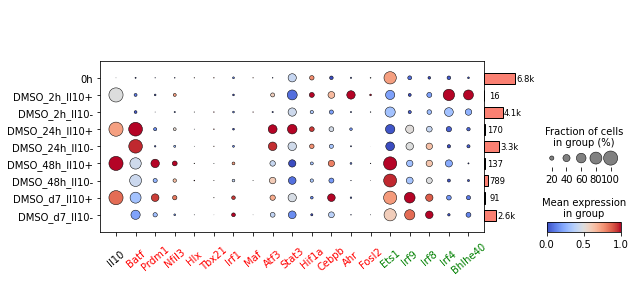

In [8]:
font = {'size' : 12}
plt.rc('font', **font)

markers = ['Il10'] + ["Batf", "Prdm1", "Nfil3", "Hlx", "Tbx21", "Irf1", "Maf", "Atf3", "Stat3", "Hif1a", "Cebpb", "Ahr", "Fosl2", 
                      "Ets1", "Irf9", "Irf8", "Irf4", "Bhlhe40"]
dp = sc.pl.dotplot(adata[adata.obs.cond != "N6"], markers, groupby="heatmap", return_fig = True,
                  swap_axes = False, standard_scale = 'var')

dp = dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5, cmap = "coolwarm")
ax = dp.get_axes()['mainplot_ax']
ax.set_xticklabels(markers, rotation = 40, va="center", position=(0,-0.11))

for ticklabel, tickcolor in zip(ax.get_xticklabels(), ['black']+['red']*13+['green']*15):
    ticklabel.set_color(tickcolor)

plt.savefig("figures/biblio_il10_dotplot_dmso.pdf", bbox_inches='tight')

# 6. UMAPs

In [61]:
# Load the pre-processed data
with open('saved_objects/adata_annotated.pkl', 'rb') as inp:
    adata = pickle.load(inp)

adata.X = adata.raw.X
sc.pp.log1p(adata)

In [145]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 90))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,10))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

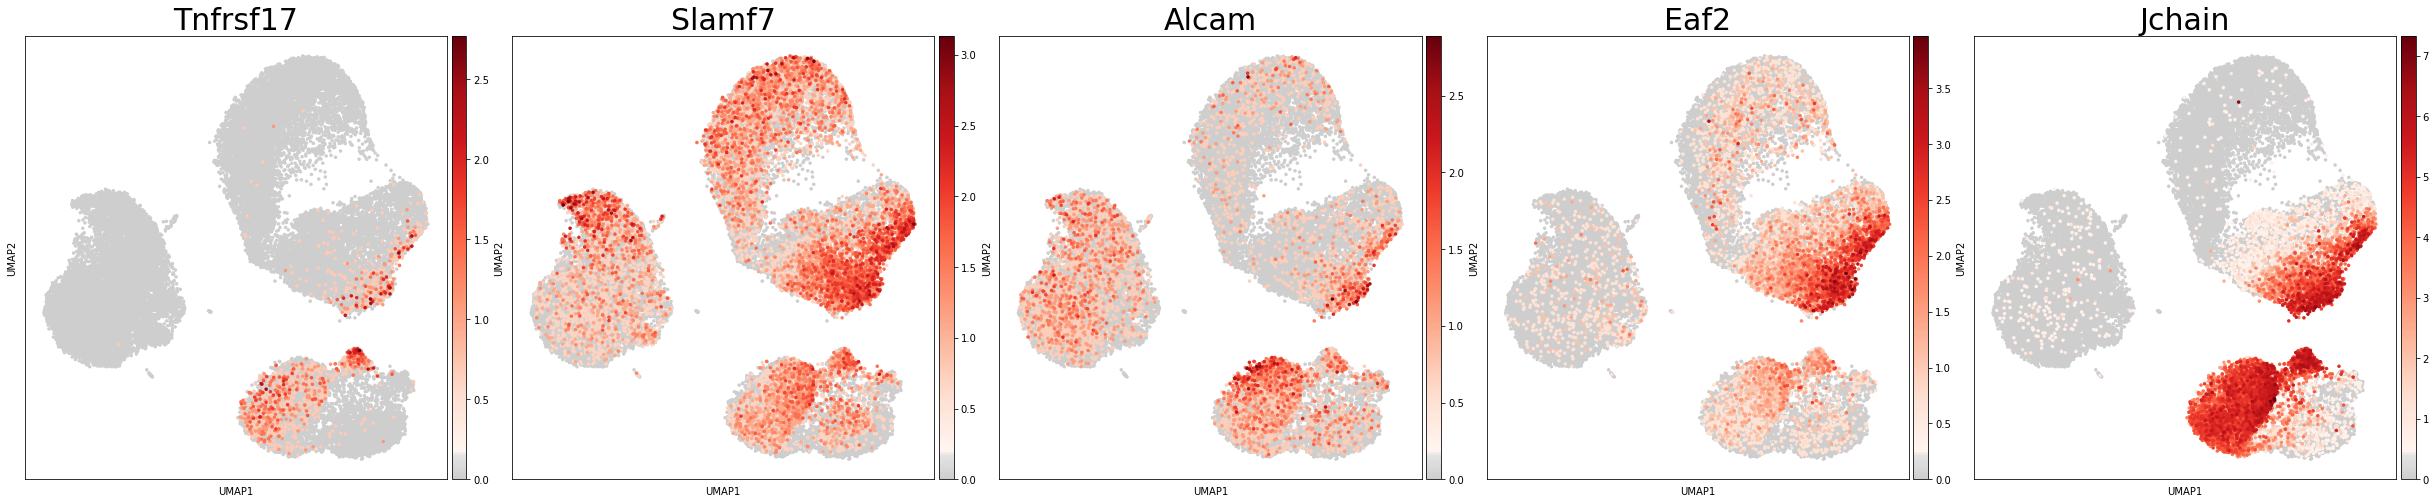

In [125]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
plt.rcParams.update({'axes.titlesize' : 30})

markers = ['Tnfrsf17', 'Slamf7', 'Alcam', 'Eaf2', 'Jchain']
#[adata.X[:, adata.var.gene_name == "Epcam"] < 10]
sc.pl.umap(adata, cmap=mymap, color = markers, size = 50, wspace = 0.05, hspace = 0.12, ncols = 5, save="_PC_biblio.png")

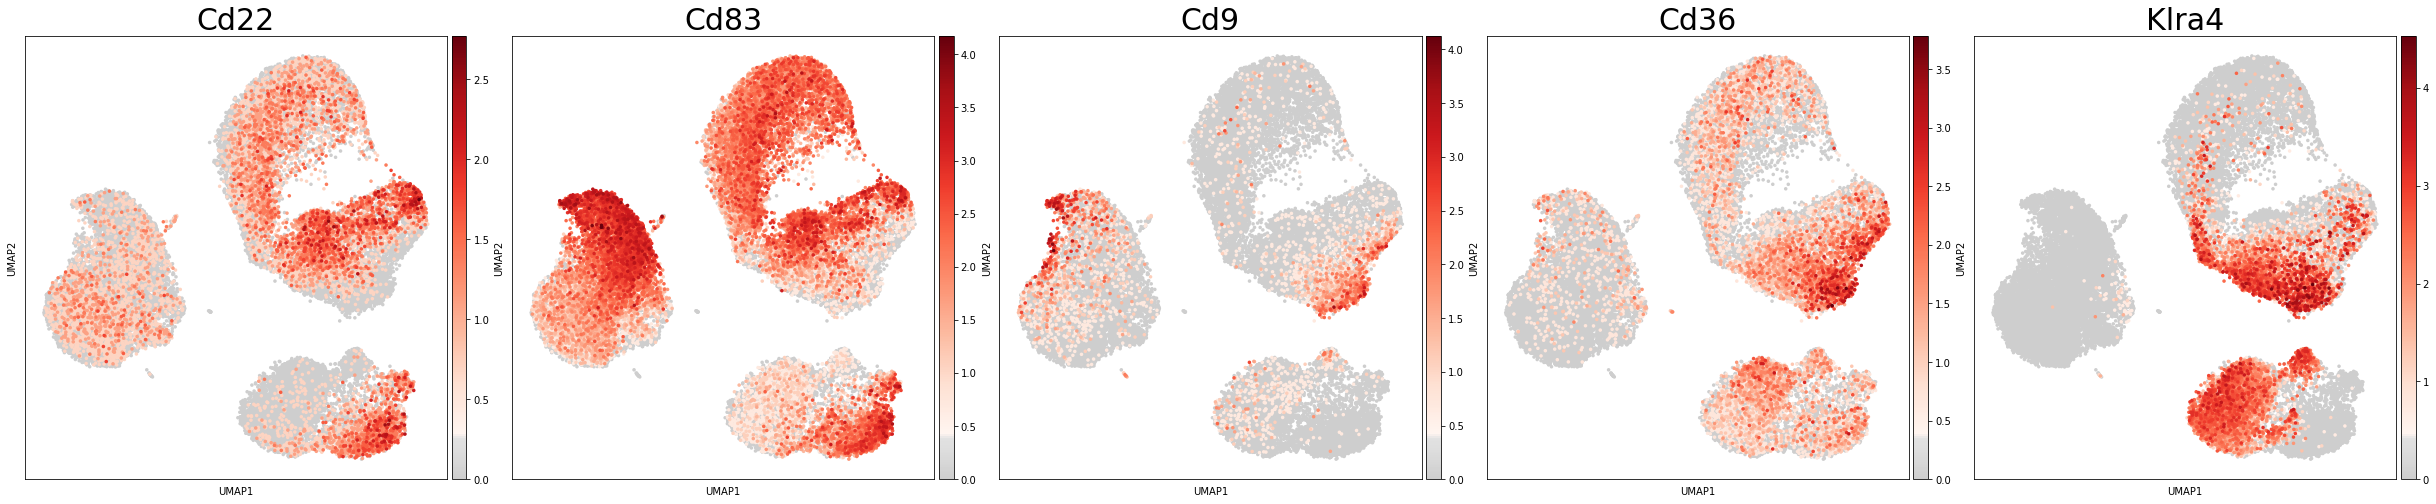

In [62]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
plt.rcParams.update({'axes.titlesize' : 30})

markers = ['Cd22', 'Cd83', 'Cd9', 'Cd36', 'Klra4']

sc.pl.umap(adata, cmap=mymap, color = markers, size = 50, wspace = 0.05, hspace = 0.12, ncols = 5, save="_surface.png")